In [1]:
import healpy as hp
import numpy as n_p
import matplotlib.pyplot as plt
import os
from os.path import join as opj

from plancklens import utils

from delensalot.core import cachers

#from lenspyx.remapping import utils_geom as utils_scarf
#from delensalot.core.secondaries import secondaries

%reload_ext autoreload
%autoreload 2


mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
import os
import numpy as np

import logging
log = logging.getLogger(__name__)
from logdecorator import log_on_start, log_on_end

alm2rlm = lambda x : x.copy()
rlm2alm = lambda x : x.copy()

#TODO this looks like a 'query' class to me. May be refactored.
class rec:
    """Static methods to reach for iterated lensing maps etc


    """

    @staticmethod
    def maxiterdone(lib_dir):
        lib_dir = os.path.abspath(lib_dir)
        itr = -2
        isdone = True
        while isdone:
            itr += 1
            isdone = rec.is_iter_done(lib_dir, itr + 1)
        return itr

    @staticmethod
    def load_plms(lib_dir, itrs):
        """Loads plms for the requested itrs"""
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        itmax = np.max(itrs)
        sk_fname = lambda k: os.path.join(lib_dir, 'hessian', 'rlm_sn_%s_%s' % (k, 'p'))
        rlm = alm2rlm(cacher.load(os.path.join(lib_dir, 'phi_plm_it000')))
        ret = [] if 0 not in itrs else [rlm2alm(rlm)]
        for i in range(itmax):
            if cacher.is_cached(sk_fname(i)):
                rlm += cacher.load(sk_fname(i))
                if (i + 1) in itrs:
                    ret.append(rlm2alm(rlm))
            else:
                log.info("*** Could only build up to itr number %s"%i)
                return ret
        return ret

    @staticmethod
    def load_elm(lib_dir, itr):
        """Load delensing E-map at iteration 'itr'

        """
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        e_fname = os.path.join(lib_dir, 'wflms', 'wflm_%s_it%s' % ('p', itr))
        assert cacher.is_cached(e_fname), 'cant load ' + e_fname
        return cacher.load(e_fname)

    @staticmethod
    def is_iter_done(lib_dir, itr):
        """Returns True if the iteration 'itr' has been performed already and False if not

        """
        lib_dir = os.path.abspath(lib_dir)
        if not os.path.exists(lib_dir): return False
        cacher = cachers.cacher_npy(lib_dir)
        if itr <= 0:
            return cacher.is_cached('%s_plm_it000' % ({'p': 'phi', 'o': 'om'}['p']))
        sk_fname = lambda k: os.path.join(lib_dir, 'hessian', 'rlm_sn_%s_%s' % (k, 'p'))
        return cacher.is_cached(sk_fname(itr - 1))

    @staticmethod
    def load_grad(lib_dir, itr):
        #FIXME: load gradient at zero
        assert 0, 'fix gradient load at 0'
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        yk_fname = lambda k: os.path.join(lib_dir, 'hessian','rlm_yn_%s_%s' % (k, 'p'))
        rlm = alm2rlm(load_gradient(0, 'p'))
        for i in range(itr):
            rlm += cacher.load(yk_fname(i))
        return rlm2alm(rlm)

In [3]:
cls_path = opj(os.environ['HOME'], 'fgcmblensing', 'input', 'giulio')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))

## Compare reconstruction of $\phi$ from joint module vs baseline module

In [4]:
from plancklens import utils
from iterativefg import utils as itu

bin_edges = np.arange(10, 4000, 60)

In [5]:
def cross_corr_coeff(a, b, base = 0, color = None, plot = True, ax = None, label = None):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: itu.bin_theory(x, bin_edges)
    el, x =  decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = x**2/(aa*bb)
    if plot:
        if ax is None:
            plt.plot(el, xcorr-base, color = color, label = label)
        else:
            ax.plot(el, xcorr-base, color = color, label = label)
    return xcorr

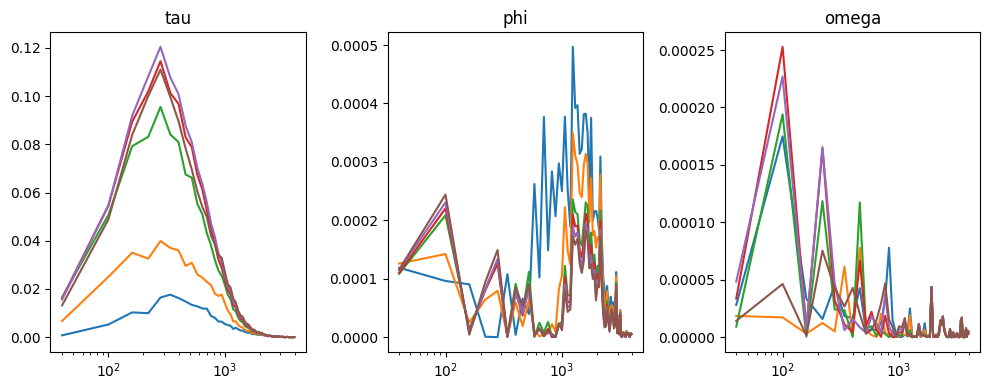

In [15]:
cmbversion = "experiment_tau_only"
cmbversion = "experiment_tau_lensing"
do_lensing = True

scratch = os.environ["SCRATCH"]+"/JOINTRECONSTRUCTION"
scratch_dir = f"{scratch}/{cmbversion}/"

dir = f"{scratch_dir}/simswalpha/"


tau = hp.read_alm(dir+"sim_0000_tau_lm.fits").astype(np.complex128)
tau = utils.alm_copy(tau, lmax = 5120)

if do_lensing:
    phi = hp.read_alm(dir+"sim_0000_plm.fits").astype(np.complex128)
    phi = utils.alm_copy(phi, lmax = 5120)


version = "experiment_tau_1"
version = "experiment_tau_lensing_2"

its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/p_p_sim0000{version}/"

itrs = [0, 1, 3, 4, 5, 6]
recs = rec()
directory_reconstruction = its_folder
plms = recs.load_plms(directory_reconstruction, itrs = itrs)

tau_index = 0
phi_index = 1
omega_index = 2

indices = [tau_index, phi_index, omega_index]

names = ["tau", "phi", "omega"]

fields = [tau, tau, tau]
#if do_lensing:
#    fields = [tau, phi, tau]


ncomps = len(indices)


fig, ax = plt.subplots(nrows = 1, ncols = ncomps, figsize = (10, 4))
if ncomps == 1:
    ax = [ax]

for index in indices:
    field = fields[index]
    #field_other = fields_other[index]
    ax[index].set_title(names[index])
    for idx, itr in enumerate(itrs):
        p = np.split(plms[idx], ncomps)[index] if (plms[idx].size % ncomps == 0) else plms[idx]
        if idx == 0:
            xcorr = cross_corr_coeff(p, field, plot = False)
            #xcorr_other = cross_corr_coeff(p, field_other, plot = False)

        cross_corr_coeff(p, field, base = 0, ax = ax[index])
        #cross_corr_coeff(p, field_other, base = 0, ax = ax[index])

    ax[index].set_xscale("log")
    
fig.tight_layout()



In [55]:
alpha_index = 0
phi_index = 1
omega_index = 2

indices = [alpha_index, phi_index, omega_index]

names = ["alpha", "phi", "omega"]
names = ["tau", "phi", "omega"]

fields_other = [phi, alpha, alpha]
fields = [alpha, phi, alpha]


ncomps = len(indices)

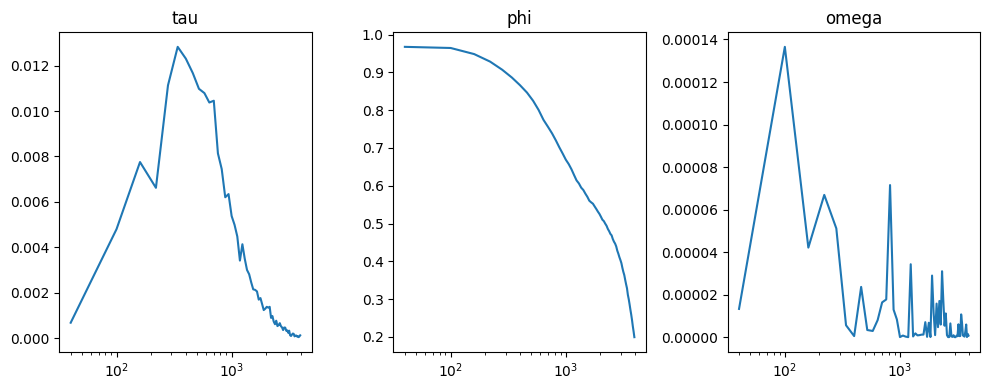

In [59]:
fig, ax = plt.subplots(nrows = 1, ncols = ncomps, figsize = (10, 4))

for index in indices:
    field = fields[index]
    field_other = fields_other[index]
    ax[index].set_title(names[index])
    for idx, itr in enumerate(itrs):
        p = np.split(plms[idx], ncomps)[index] if (plms[idx].size % ncomps == 0) else plms[idx]
        if idx == 0:
            xcorr = cross_corr_coeff(p, field, plot = False)
            xcorr_other = cross_corr_coeff(p, field_other, plot = False)

        cross_corr_coeff(p, field, base = 0, ax = ax[index])
        #cross_corr_coeff(p, field_other, base = 0, ax = ax[index])

    ax[index].set_xscale("log")
    
fig.tight_layout()

#cross_corr_coeff(alpha_both, alpha_both, base = 1, color = "black")
#plt.loglog(-hp.alm2cl(plms[0], -alpha_both))
#plt.loglog(-hp.alm2cl(plms[0]-diff, alpha_both))


In [58]:
#Check WF for alpha
index = 0 #alpha
idx = 0 # QE

Nsims = 8
mean_cross = 0
mean_alpha = 0

for simidx in range(Nsims):

    its_folder = f"{scratch}/{cmbversion}recs/p_p_sim{simidx:04}{version}/"
    plms = recs.load_plms(its_folder, itrs = [0])

    alpha = hp.read_alm(dir+f"sim_{simidx:04}_alpha_lm.fits").astype(np.complex128)
    alpha = utils.alm_copy(alpha, lmax = 5120)

    p = np.split(plms[idx], ncomps)[index]
    cross = -hp.alm2cl(p, alpha)
    auto_alpha = hp.alm2cl(alpha)

    mean_cross += cross
    mean_alpha += auto_alpha

mean_cross /= Nsims
mean_alpha /= Nsims

plt.plot(mean_cross/mean_alpha)
plt.plot(WF, lw = 2)
plt.xscale("log")

AssertionError: /scratch/snx3000/odarwish/JOINTRECONSTRUCTION/phi_tau_joint_provarecs/p_p_sim0000phi_tau_joint_prova_low/phi_plm_it000.npy

In [101]:
blm = hp.read_alm("/scratch/snx3000/odarwish/alpha/simswalpha/"+"sim_0014_blm.fits")
elm = hp.read_alm("/scratch/snx3000/odarwish/alpha/simswalpha/"+"sim_0014_elm.fits")

In [65]:
dir = f"{scratch_dir}/simswalpha/"

from classy import Class

params = {
"output": "tCl,pCl,rCl",
"l_max_scalars": 4000 ,
"rotation": " yes ",
"alpha": 0. ,
"A_cb": 1e-7,
}

cosmo = Class()
cosmo.set(params)
cosmo.compute(level = ["rotation"])
cls = cosmo.rotated_cl()

In [99]:
params = {
    "output" : " tCl,pCl,rCl", #lCl, rCl" ,
    "l_max_scalars" : 4000,
    #"lensing": 'yes',
    "rotation": 'yes',
    "alpha" : 0.,
    "A_cb" : 1e-7,
    "omega_b" : 0.022445,
    "omega_cdm" : 0.1212,
    "h" : 0.67,
    "n_s" : 0.96,
    "A_s" : 2.1265e-09
}

cosmo = Class()
cosmo.set(params)
cosmo.compute(level=['rotation'])

raw_cls = cosmo.raw_cl()
#lensed_cls = cosmo.lensed_cl()
rotated_lensed_cls = cosmo.rotated_cl()

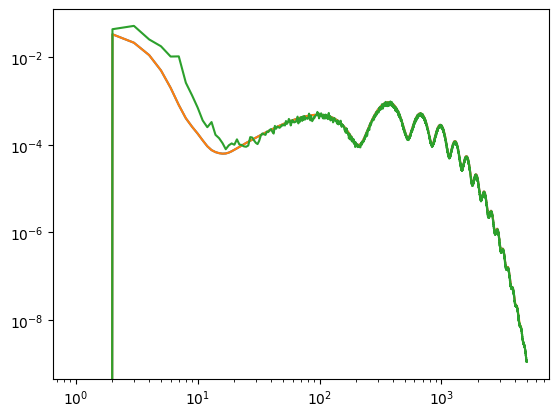

In [105]:
Tcmb = 2.72e6

bmode = False
key = "bb" if bmode else "ee"
x = blm if bmode else elm

plt.loglog(rotated_lensed_cls[key]*Tcmb**2)
#plt.loglog(lensed_cls["bb"])
plt.loglog(raw_cls[key]*Tcmb**2)
plt.plot(hp.alm2cl(x))